

# Generating Shakespeare with a Character-Level RNN


In this part, we'll turn from traditional n-gram based language models to a more advanced form of language modeling using a Recurrent Neural Network. Specifically, we'll be setting up a character-level recurrent neural network (char-rnn) for short.

Andrej Karpathy, a researcher at OpenAI, has written an excellent blog post about using RNNs for language models, which you should read before beginning this assignment.  The title of his blog post is [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

Karpathy shows how char-rnns can be used to generate texts for several fun domains:
* Shakespeare plays
* Essays about economics
* LaTeX documents
* Linux source code
* Baby names

<div class="alert alert-info" markdown="1">
Here are the materials that you should download for this assignment:

* [training data and devlopment data for generation](https://www.cc.gatech.edu/classes/AY2020/cs7650_spring/hw3/lm/data.zip).
</div>

# Recommended Reading

You should install PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

## You can also set up Pytorch in Google Colab

Pytorch is one of the most popular deep learning frameworks in both industry and academia, and learning its use will be invaluable should you choose a career in deep learning. 

### Setup
#### Using Google Colab (recommended)
1. Upload this notebook on [Colab](https://colab.research.google.com/notebooks/welcome.ipynb).
2. Set hardware accelerator to ```GPU``` under ```notebook settings``` in the ```Edit``` menu.
3. Run the first cell to  set up  the environment.

### Note
Please look at the FAQ section before you start working.


# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [1]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('data/shakespeare_input.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4573338


To make inputs out of this big string of data, we will be splitting it into chunks.

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

s was sequent
Thou know'st already.

HORATIO:
So Guildenstern and Rosencrantz go to't.

HAMLET:
Why, man, they did make love to this employment;
They are not near my conscience; their defeat
Does by th


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution. You need to finish the forward method. (Refer to [Pytorch GRU Documentation](https://pytorch.org/docs/stable/nn.html#gru))

In [40]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size    # 100
        self.hidden_size = hidden_size    # 100
        self.output_size = output_size    # 100
        self.n_layers = n_layers    # 1
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        print(self.gru.weight_ih_l0.shape)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        #Input input: torch Tensor of shape (1,)
        #hidden: torch Tensor of shape (self.n_layers, 1, self.hidden_size)
        #Return output: torch Tensor of shape (1, self.output_size) 
        #and hidden: torch Tensor of shape (self.n_layers, 1, self.hidden_size)
        
        # embed input
        encode_layer = self.encoder(input).reshape(1,1,-1)
        y, hidden = self.gru(encode_layer, hidden)
        y = self.decoder(y.reshape(1,-1))
        return y, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).to(device)

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [27]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long().to(device)
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [28]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [29]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [30]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [31]:
def train(inp, target):
#     print('inp', inp)
    hidden = decoder.init_hidden()
#     print('hidden', hidden.shape)
    decoder.zero_grad()
    loss = 0
#     print('chunk_len', chunk_len)
    for c in range(chunk_len):
#         print('inp[c], hidden', inp[c], hidden.shape)
        output, hidden = decoder(inp[c], hidden)
#         print('target.unsqueeze(1)[c]', target.unsqueeze(1)[c].shape)
        loss += criterion(output, target.unsqueeze(1)[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [41]:
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
lr = 0.0005
print('parameters => ', n_characters, hidden_size, n_characters, n_layers)
decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

parameters =>  100 256 100 2
torch.Size([768, 256])
 39s (100 1%) 2.5673]
Wh%asbf is wapgane le hand hal gese the hand wethre moy I eoused ve ly minn nanveore the myan hand inu 

 26s (200 2%) 2.4654]
WhQatily so an.

L-ROKEEI:
And of in and thou leld, wold dFer inith il.

NIT
No whs sto to thigy rall  

 6s (300 3%) 2.2788]
Whe deare'd the aftrose, his hat ther, the to deme mat by wits coo<n cat's wentuy not matseos hat to t 

 45s (400 4%) 2.0963]
Whall and our beaversen, this this mut of ou, Searn sall ind bearmon; and there paves
Andern!

CORCE:
 

 34s (500 5%) 1.9813]
Whia to he ofour manston hin the, I ake with it upetiess to withs the mowef do bet outher kir?

BENMIN 

 15s (600 6%) 1.8821]
What heard hom, onges as him
Intin:
The he ounder him the sourone,
I, a with and to have of eartlbine, 

 55s (700 7%) 2.2878]
Wher shere be thence the dotsen,
And the neving was a and dows:
What beat the ringue enave like this t 

 34s (800 8%) 1.7517]
What to munt the!

ONAMDADNOW:
My say 

 23s (6300 63%) 1.5855]
Whats my hand, my lates
a gracious plain yet madine-face, Bury the was of burims zillors?

PEROTE:
Wat 

 59s (6400 64%) 2.0329]
What have a moraling:
When the catrucusured from like my eyes
Think would have hence, that is it with  

 36s (6500 65%) 1.4356]
Wherefore there's that I child
I do stay! I say, like throng thee thy fair
And mean of Brombs for if t 

 12s (6600 66%) 1.3553]
Who beary upbreat.

First Soldier:
For your good slove meant your old men.

PRINCEL:
I warrant boy, th 

 48s (6700 67%) 1.4326]
While to patch; and for a still
Shall breath lived that thou
be father to my reason worse to we comman 

 25s (6800 68%) 1.1137]
Why your highness
The father.

BENADIA:
My lord, must well, and want alvest roof the king,
And was tho 

 1s (6900 69%) 1.7395]
When prove up and of my highations.

SALWOLI:
A brother, count free them two speak,
and if the surken  

 38s (7000 70%) 1.5456]
Where, that let my Martible dear heaven
cast upon there so streppus, with 

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

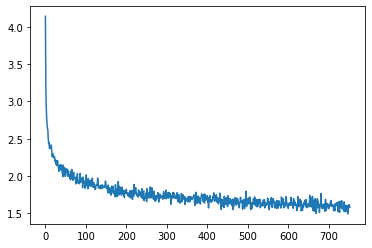

In [18]:
# n_epochs = 10000
# print_every = 100
# plot_every = 10
# hidden_size = 200
# n_layers = 1
# lr = 0.001
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

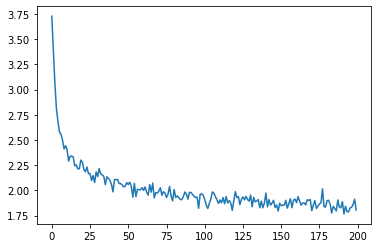

In [10]:
# n_epochs = 2000
# print_every = 100
# plot_every = 10
# hidden_size = 100
# n_layers = 2
# lr = 0.005
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

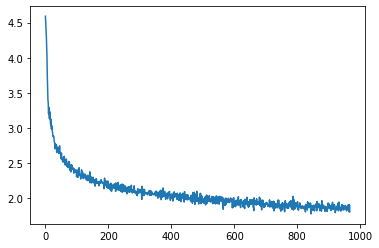

In [10]:
# n_epochs = 10000
# print_every = 100
# plot_every = 10
# hidden_size = 200
# n_layers = 1
# lr = 0.0001
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

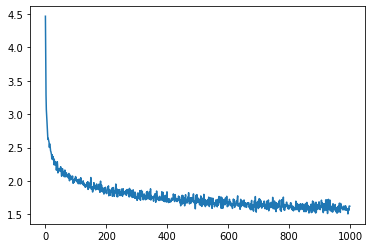

In [15]:
# n_epochs = 10000
# print_every = 100
# plot_every = 10
# hidden_size = 200
# n_layers = 1
# lr = 0.0005
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

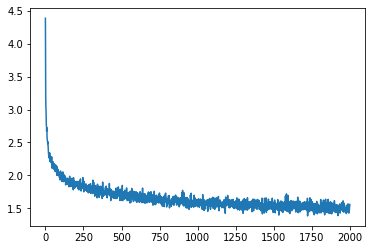

In [17]:
# n_epochs = 20000
# print_every = 100
# plot_every = 10
# hidden_size = 200
# n_layers = 1
# lr = 0.0005
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

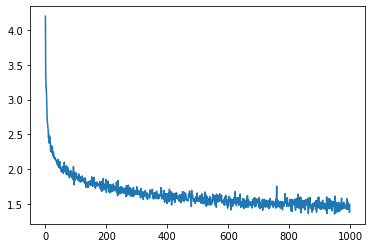

In [42]:
# n_epochs = 10000
# print_every = 100
# plot_every = 10
# hidden_size = 256
# n_layers = 2
# lr = 0.0005
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [46]:
print(evaluate('Th', 200, temperature=0.8))

Ther deathes, as I love and offengeth
Or out of commpains nor tricle thyself;
I know the years, and straight, lever thee;
You shall
keep's a king to words.

ERDIANO MACBETH:
Come, the name that pleased 


Lower temperatures are less varied, choosing only the more probable outputs:

In [44]:
print(evaluate('Th', 200, temperature=0.2))

The next be some offence,
And the princes to the country to the present
The princes and the present the perposed the bears
And the courtesy some friends and bears the dear
That the fortune that the prin


Higher temperatures more varied, choosing less probable outputs:

In [45]:
print(evaluate('Th', 200, temperature=1.4))

The, come eaters tle ssond of?
Ancount oad: thou butt the weak, Witremit.
Brothes! Our
Durgiar bRRANHARIO:
Uphad I hast amshiffed poistion? so into your king
To Engltif, areay, and, letter's fairs.
Answ


In [43]:
# n = 2 Perplexity: 7.022691249847412
# n = 1 Perplexity: 7.022691249847412
# lr = 0.001; n_epochs = 10000; Perplexity: 6.100185394287109
# lr = 0.0001; n_epochs = 10000; Perplexity: 6.9812726974487305
# lr = 0.0005; n_epochs = 10000; Perplexity: 5.950992584228516
# lr = 0.0005; n_epochs = 20000; Perplexity: 5.700932502746582
# lr = 0.0005; n_epochs = 10000; n =  2; Perplexity: 5.414178848266602
import torch.nn.functional as F
def perp(testfile):
    inp = char_tensor(testfile[:-1])
    target = char_tensor(testfile[1:])
    test_len=len(testfile)
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    perplexity=torch.tensor(0.0)

    for c in range(test_len-1):
        output, hidden = decoder(inp[c], hidden)
        perplexity -=F.log_softmax(output,dim=1)[0][target[c]]

    return (perplexity/test_len).exp().item()

testfile = unidecode.unidecode(open('data/shakespeare_sonnets.txt').read())
print('Perplexity:',perp(testfile))

Perplexity: 5.414178848266602


## FAQs

#### I'm unfamiliar with PyTorch. How do I get started?
If you are new to the paradigm of computational graphs and functional programming, please have a look at this [tutorial](https://hackernoon.com/linear-regression-in-x-minutes-using-pytorch-8eec49f6a0e2) before getting started.

#### How do I speed up training?
Send the model and the input, output tensors to the GPU using ```.to(device)```. Refer the [PyTorch docs](https://pytorch.org/docs/stable/notes/cuda.html) for further information.
